In [1]:
import numpy as np
import pandas as pd
import arviz as az
import matplotlib.pyplot as plt
import pymc as pm

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.0.1


In [3]:
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Data

See other notebooks for details about data preparation.

In [4]:
df = pd.read_pickle('fulldataframe.pkl')
df

,date,LosAngelesCA,NewYorkNY,RaleighNC,OklahomaCityOK,SaltLakeCityUT,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,LosAngelesUnemployment,NewYorkUnemployment,RaleighUnemployment,SaltLakeCityUnemployment,OklahomaCityUnemployment
0,2000-01-31,240598.0,226266.0,176753.0,91918.0,190020.0,8.25,2.785584,82.0,67.0,5.1,5.1,2.5,3.1,2.9
1,2000-02-29,241457.0,227618.0,176909.0,92156.0,190141.0,8.31,3.416809,79.0,78.0,5.1,5.0,2.6,3.4,3.0
2,2000-03-31,242727.0,228829.0,177351.0,92378.0,190386.0,8.23,2.276901,86.0,88.0,5.1,4.8,2.4,3.3,2.8
3,2000-04-30,245142.0,231213.0,178077.0,92742.0,190866.0,8.13,2.853534,80.0,78.0,5.1,4.1,2.0,2.9,2.2
4,2000-05-31,247707.0,233418.0,179033.0,93124.0,193543.0,8.62,3.142535,84.0,77.0,5.1,4.3,2.5,3.0,2.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,2022-07-31,988839.0,620305.0,462448.0,220174.0,625456.0,5.30,9.222973,43.0,44.0,4.3,4.7,3.1,2.1,2.9
271,2022-08-31,973842.0,622586.0,459364.0,221448.0,611770.0,5.55,8.307776,46.0,51.0,4.1,4.9,3.3,2.1,3.1
272,2022-09-30,963691.0,623535.0,454956.0,222529.0,606227.0,6.70,6.532852,55.0,45.0,4.1,3.7,2.8,1.9,3.1
273,2022-10-31,953568.0,623959.0,452496.0,223638.0,602751.0,7.08,5.609658,59.0,45.0,4.0,3.7,3.3,2.1,3.3


In [5]:
standard_features = ['date', 'MORTGAGE30US', 'MedianCPI', 'HomesForSale', 'HomesSold']

la_df = df[standard_features + ['LosAngelesCA', 'LosAngelesUnemployment']]
la_df.set_index('date', inplace=True)
la_df

,MORTGAGE30US,MedianCPI,HomesForSale,HomesSold,LosAngelesCA,LosAngelesUnemployment
date,,,,,,
2000-01-31,8.25,2.785584,82.0,67.0,240598.0,5.1
2000-02-29,8.31,3.416809,79.0,78.0,241457.0,5.1
2000-03-31,8.23,2.276901,86.0,88.0,242727.0,5.1
2000-04-30,8.13,2.853534,80.0,78.0,245142.0,5.1
2000-05-31,8.62,3.142535,84.0,77.0,247707.0,5.1
...,...,...,...,...,...,...
2022-07-31,5.30,9.222973,43.0,44.0,988839.0,4.3
2022-08-31,5.55,8.307776,46.0,51.0,973842.0,4.1
2022-09-30,6.70,6.532852,55.0,45.0,963691.0,4.1


In [6]:
sample_df = la_df[['LosAngelesCA', 'MORTGAGE30US']]
sample_df

,LosAngelesCA,MORTGAGE30US
date,,
2000-01-31,240598.0,8.25
2000-02-29,241457.0,8.31
2000-03-31,242727.0,8.23
2000-04-30,245142.0,8.13
2000-05-31,247707.0,8.62
...,...,...
2022-07-31,988839.0,5.30
2022-08-31,973842.0,5.55
2022-09-30,963691.0,6.70


In [7]:
data = sample_df.diff().dropna()
data.head(10)

,LosAngelesCA,MORTGAGE30US
date,,
2000-02-29,859.0,0.06
2000-03-31,1270.0,-0.08
2000-04-30,2415.0,-0.10
2000-05-31,2565.0,0.49
2000-06-30,2432.0,-0.40
2000-07-31,2497.0,-0.09
2000-08-31,2615.0,-0.14
2000-09-30,2486.0,-0.11
2000-10-31,2272.0,-0.20


# Frequentist VAR

We will verify our implementation of BVAR by comparing it to the frequentist VAR implemented in statsmodels.

In [8]:
import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [9]:
model = VAR(data)

/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


In [10]:
results=model.fit(maxlags=2)

In [11]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Feb, 2023
Time:                     11:49:24
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    12.4869
Nobs:                     272.000    HQIC:                   12.4076
Log likelihood:          -2442.10    FPE:                    231975.
AIC:                      12.3544    Det(Omega_mle):         223676.
--------------------------------------------------------------------
Results for equation LosAngelesCA
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                 233.066270       139.763804            1.668           0.095
L1.LosAngelesCA         1.212463         0.057998           20.905           0.000
L1.MORTGAGE30US      1395.820377       561.18

# Bayesian VAR

In [12]:
class BVAR:
    def __init__(self, df, lags=1, intercept_mean = 0, intercept_std = 10, 
                 lag_mean=0, lag_std=10, noise_std=10, minimal_noise = False):
        self.data = df
        self.trace = None
        self.minimal_noise = minimal_noise
        
        coords = {
            "lags": reversed(range(-lags, 0)),
            "vars": list(df.columns),
            "cross_vars": list(df.columns),
            "time": range(len(df) - lags),
        }
        
        self.model = pm.Model(coords=coords)
        
        with self.model:
            # Define priors for intercepts, lag coefficients, and noise if using
            intercept = pm.Normal("intercept", mu=intercept_mean, sigma=intercept_std, dims=("vars",))
            lag_coefs = pm.Normal("lag_coefs", mu=lag_mean, sigma=lag_std, dims=("lags", "vars", "cross_vars"))
            if minimal_noise is True:
                noise = 1
            else:
                noise = pm.HalfNormal("noise", sigma=noise_std, dims=("vars",))

            # Define priors for autoregression expectations
            ar_terms = []

            for j in range(len(df.columns)):
                # for each variable, convolve its matrix of lag coefficients over the dataframe
                # inner sum sums across variables, outer sum sums across lags
                ar = pm.math.sum([
                    pm.math.sum(lag_coefs[i, j] * df.values[lags-(i+1): -(i+1)], axis=1)
                    for i in range(lags)
                ], axis=0)
                ar_terms.append(ar)

            # Add intercept terms to autoregression expectations
            mean = intercept + pm.math.stack([ar for ar in ar_terms], axis=-1)

            # Define our observed stochastic variable. Restrict to observations that have lags available.
            obs = pm.Normal("obs", mu=mean, sigma=noise, observed=df[lags:], dims=("time", "vars"))
    
    def fit(self, draws=1000, tune=1000, chains=4, random_seed=None):
        with self.model:
            self.trace = pm.sample(draws=draws, tune=tune, chains=chains, random_seed=random_seed, 
                                   idata_kwargs={"log_likelihood": True})
            
    def get_trace(self):
        if self.trace is not None:
            return self.trace
        else:
            raise Exception('Model not fitted. Fit model before proceeding.')
            
    def _forecast_single(self, df, intercept, lag_coefs, noise, horizon, rng):
        num_lags = len(lag_coefs.coords['lags'])
        df = df.copy() # assume we may need this to prevent issues. TODO: determine if needed

        # Extend the horizon of the time series data, filling future values with NaN defaults
        df = df.reindex(df.index.union(df.index.shift(horizon, 'M')))

        for t in range(-1 * horizon, 0):
            lagslice = df[t - num_lags:t or None].values # "or None" ensures last iteration does not return empty list
            var_means = np.sum(lag_coefs * lagslice, axis=(-1, -2)) # broadcast lags to timesteps and cross-vars to vars
            var_vals = intercept + var_means + rng.normal(0, noise, size=(var_means.shape))
            df.iloc[t] = var_vals

        return df
        
    def forecast(self, df=None, trace=None, horizon=1, draws=100, use_mean_parameters=False, rng=np.random.default_rng()):
        if df is None:
            df = self.data
            
        if trace is None:
            trace = self.get_trace()
        
        # TODO: functionality for point predictions based on mean values of posterior parameters
        
        post = trace.posterior.stack(sample=("chain", "draw"))
        post = post.transpose('sample', 'vars', 'lags', 'cross_vars') # reorder dims for indexing and broadcasting
        
        samples_length = post.dims['sample']
        random_idxs = rng.integers(samples_length, size=draws) 
        
        intercept_samples = post['intercept'].isel(sample=random_idxs)
        lag_coefs_samples = post['lag_coefs'].isel(sample=random_idxs)
        if self.minimal_noise is False:
            noise_samples = post['noise'].isel(sample=random_idxs) 
        else:
            noise_samples = np.ones(shape=(intercept_samples.shape[0],))
        
        return [self._forecast_single(df, intercept_samples[i], lag_coefs_samples[i], noise_samples[i], horizon, rng) 
                for i in range(draws)]
    
    def summary(self):
        if self.trace is None:
            raise Exception('Model not fitted. Fit model before proceeding.')
        
        return az.summary(self.trace)
    
    def plot_trace(self):
        if self.trace is None:
            raise Exception('Model not fitted. fit model before proceeding.')
        az.plot_trace(self.trace, compact=False)
        

In [13]:
BVAR_model = BVAR(data, lags=2)
BVAR_model.fit(random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs, noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 11 seconds.


## Fit examination

The below plots show the posterior distributions over the model's parameters. The naming convention  for lag coefficients uses a negative number to indicate the number of lags, then the dependent variable, then the independnet variable. For example: "-2, LosAngelesCA, LosAngelesUnemployment" is the label for the coefficient for how much LosAngelesCA is impacted by the value of LosAngelesUnemployment two timesteps prior.

In [ ]:
BVAR_model.plot_trace()

The below table summarizes the posterior distributions over the parameters. The coefficients for LosAngelesCA's dependence on LosAngelesUnemployment differ significantly from the frequentist estimation. We will show below that this is attributable to the inclusion of noise at the observation-level in our model.

In [15]:
BVAR_model.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[LosAngelesCA],15.092,9.843,-3.175,33.470,0.116,0.110,7167.0,2467.0,1.00
intercept[MORTGAGE30US],-0.019,0.016,-0.046,0.011,0.000,0.000,6348.0,2529.0,1.01
"lag_coefs[-1, LosAngelesCA, LosAngelesCA]",1.204,0.016,1.172,1.232,0.000,0.000,4246.0,2645.0,1.00
"lag_coefs[-1, LosAngelesCA, MORTGAGE30US]",4.895,9.920,-13.928,23.141,0.120,0.158,7019.0,2847.0,1.00
"lag_coefs[-1, MORTGAGE30US, LosAngelesCA]",0.000,0.000,-0.000,0.000,0.000,0.000,3625.0,2921.0,1.00
"lag_coefs[-1, MORTGAGE30US, MORTGAGE30US]",0.072,0.062,-0.048,0.184,0.001,0.001,7609.0,2899.0,1.00
"lag_coefs[-2, LosAngelesCA, LosAngelesCA]",-0.285,0.016,-0.315,-0.254,0.000,0.000,4303.0,2784.0,1.00
"lag_coefs[-2, LosAngelesCA, MORTGAGE30US]",-6.140,9.981,-24.868,11.919,0.126,0.151,6203.0,2543.0,1.00
"lag_coefs[-2, MORTGAGE30US, LosAngelesCA]",0.000,0.000,-0.000,0.000,0.000,0.000,3669.0,3030.0,1.00
"lag_coefs[-2, MORTGAGE30US, MORTGAGE30US]",-0.075,0.063,-0.192,0.044,0.001,0.001,6432.0,2827.0,1.00


## Noise Minimality Experiment and Implementation Verification

The below experiment demonstrates that the difference between the above results and the frequentist estimation is due to the inclusion of sampling noise in the model. (For context, we must include sampling noise in the Bayesian model in order for the MCMC algorithm to work. See [this thread](https://discourse.pymc.io/t/observed-deterministic/483/10) for details. Instead of using no noise, our Bayesian model includes an option for minimal noise with standard deviation of 1.) The similarity of estimated parameters verifies our implementation of our BVAR model.

In [16]:
BVAR_minnoise = BVAR(data, lags=2, minimal_noise=True)
BVAR_minnoise.fit(random_seed=rng)
BVAR_minnoise.summary()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, lag_coefs]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept[LosAngelesCA],233.065,0.067,232.937,233.188,0.001,0.001,7066.0,2754.0,1.0
intercept[MORTGAGE30US],-0.020,0.065,-0.140,0.105,0.001,0.001,6522.0,2691.0,1.0
"lag_coefs[-1, LosAngelesCA, LosAngelesCA]",1.212,0.000,1.212,1.213,0.000,0.000,2932.0,2624.0,1.0
"lag_coefs[-1, LosAngelesCA, MORTGAGE30US]",1394.703,0.266,1394.204,1395.205,0.003,0.002,6916.0,2979.0,1.0
"lag_coefs[-1, MORTGAGE30US, LosAngelesCA]",0.000,0.000,-0.000,0.000,0.000,0.000,3425.0,3137.0,1.0
"lag_coefs[-1, MORTGAGE30US, MORTGAGE30US]",0.072,0.270,-0.464,0.536,0.003,0.004,7034.0,2770.0,1.0
"lag_coefs[-2, LosAngelesCA, LosAngelesCA]",-0.306,0.000,-0.307,-0.306,0.000,0.000,2888.0,2967.0,1.0
"lag_coefs[-2, LosAngelesCA, MORTGAGE30US]",-1585.621,0.266,-1586.128,-1585.128,0.004,0.003,5484.0,2802.0,1.0
"lag_coefs[-2, MORTGAGE30US, LosAngelesCA]",0.000,0.000,-0.000,0.000,0.000,0.000,3497.0,2944.0,1.0
"lag_coefs[-2, MORTGAGE30US, MORTGAGE30US]",-0.085,0.269,-0.566,0.436,0.004,0.004,5407.0,2986.0,1.0


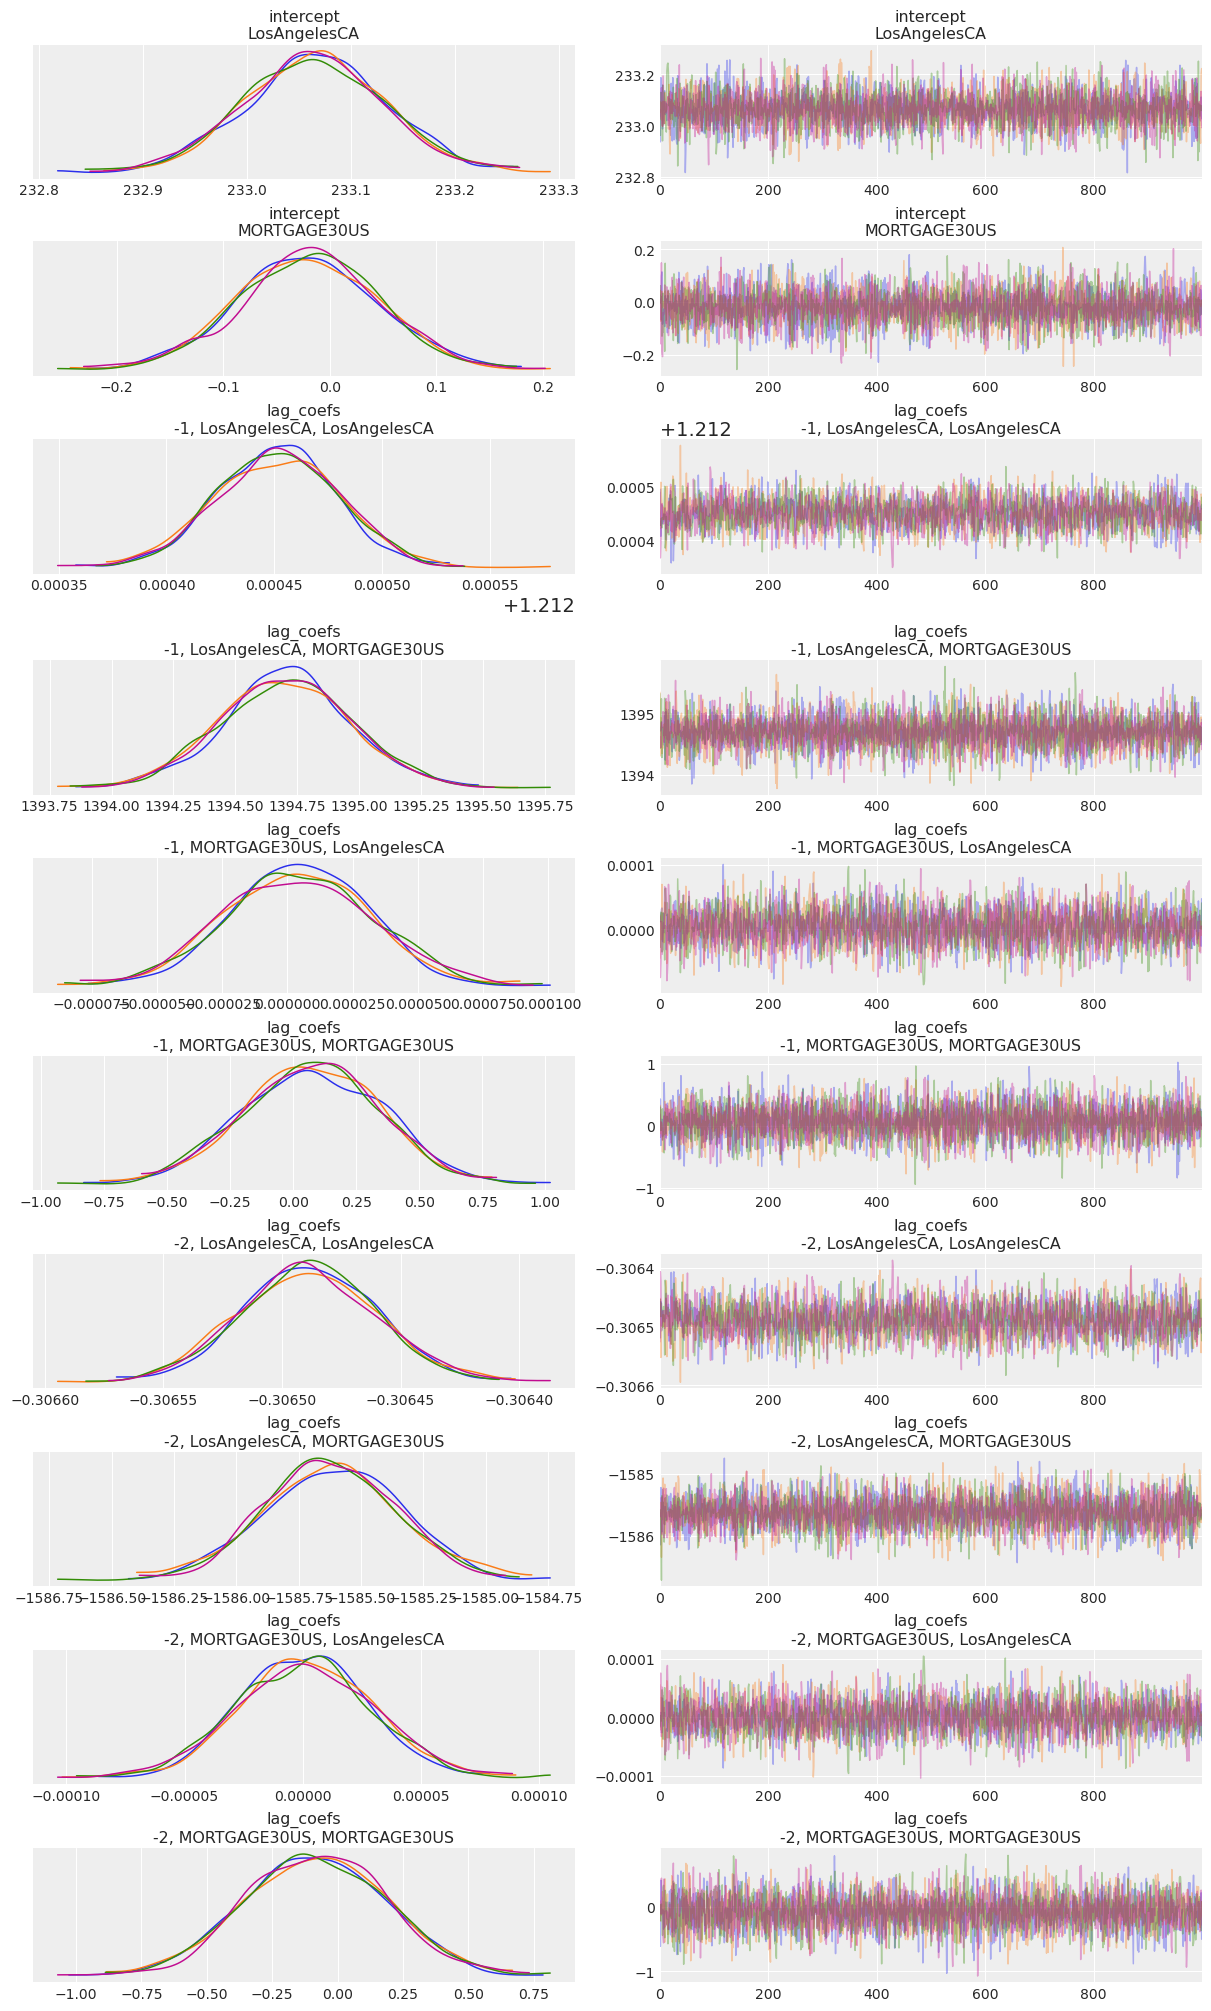

In [ ]:
BVAR_minnoise.plot_trace()

## Bayesian Model Evaluation

Since the mean parameter estimates of the minimal-noise model agree so closely with the frequentist VAR model, it would not be very informative to compare the two models on the basis of point predictions generated by mean parameter estimates. The strength of the Bayesian approach comes from being able to generate prediction distributions rather than just point predictions. This leads to using metrics other than, for example, R<sup>2</sup> to compare models. We will compare the minimal-noise and non-minimal-noise Bayesian models using measure called Pareto smoothed importance sampling leave-one-out cross validation (PSIS-LOO-CV). See [this link](https://bayesiancomputationbook.com/markdown/chp_02.html#cross-validation-and-loo) for details. This measure estimates the sum of the log-probabilities of observed datapoints integrated over the posterior distribution over model parameters generated by using leave-one-out cross validation. 

In [18]:
LAtraces = {
    "BVAR": BVAR_model.get_trace().sel(vars='LosAngelesCA'),
    "BVAR_minnoise": BVAR_minnoise.get_trace().sel(vars='LosAngelesCA')
}

az.compare(LAtraces)

/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.8/site-packages/arviz/stats/stats.py:1069: RuntimeWarning: overflow encountered in expm1
  x = np.expm1(-kappa * np.log1p(-probs)) / kappa
/opt/homebrew/Caskroom/miniforge/base/envs/bayes/lib/python3.8/site-packages/arviz/stats/stats.py:803: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
BVAR,0,-3.848469e+03,105.127188,0.000000e+00,1.0,3.855415e+02,0.000000e+00,True,log
BVAR_minnoise,1,-5.761500e+08,373891.485752,5.761461e+08,0.0,1.072286e+08,1.072282e+08,True,log


Unfortunately, the high p_loo values in both models compared to the number of parameters in the models inidcates that our models are misspecified. TODO: Redo with manually calculated LOO-CV

## Forecasting

In [46]:
def integrate(startpoint, differences):
    return startpoint + differences.cumsum()

In [19]:
forecast_draws = BVAR_model.forecast(horizon=12)

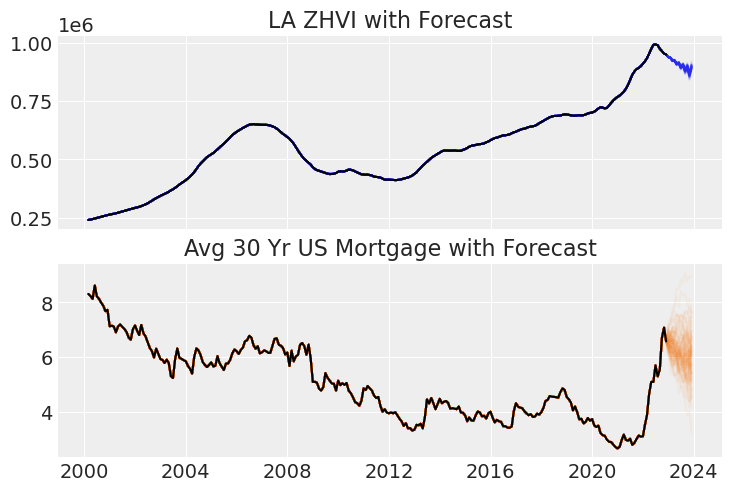

In [51]:
_, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("LA ZHVI with Forecast")
ax[1].set_title("Avg 30 Yr US Mortgage with Forecast")

for draw in forecast_draws:
    forecast = integrate(sample_df.iloc[0], draw)
    ax[0].plot(draw.index, forecast.iloc[:,0], color="C0", alpha=0.05)
    ax[1].plot(draw.index, forecast.iloc[:, 1], color="C1", alpha=0.05)

ax[0].plot(data.index, sample_df.iloc[1:,0], color="black")
ax[1].plot(data.index, sample_df.iloc[1:,1], color="black")

In [21]:
forecast_draws_minnoise = BVAR_minnoise.forecast(horizon=12)

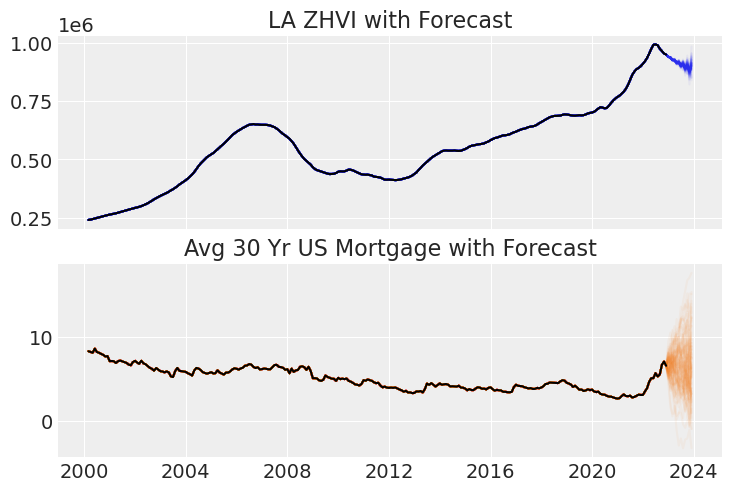

In [52]:
_, ax = plt.subplots(2, 1, sharex=True)
ax[0].set_title("LA ZHVI with Forecast")
ax[1].set_title("Avg 30 Yr US Mortgage with Forecast")

for draw in forecast_draws_minnoise:
    forecast = integrate(sample_df.iloc[0], draw)
    ax[0].plot(draw.index, forecast.iloc[:,0], color="C0", alpha=0.05)
    ax[1].plot(draw.index, forecast.iloc[:, 1], color="C1", alpha=0.05)

ax[0].plot(data.index, sample_df.iloc[1:,0], color="black")
ax[1].plot(data.index, sample_df.iloc[1:,1], color="black")

In [23]:
BVAR_model.model.mean

AttributeError: 'Model' object has no attribute 'mean'